## Downloading the PhysioNet2020-2021 waveforms and labels

In [1]:
# Preprocessing required
# Execute the file download_physionet.sh in the data/external folder

## Preparing data

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import scipy.io
import uuid
import matplotlib.pyplot as plt
import seaborn as sns
import blosc
import zstandard
import bitshuffle
import pickle

In [3]:
# Find the paths for all data files and the matching header files.
dat_files = glob.glob('../../data/external/**/*.mat') # For each folder, find *.mat files
hea_files = glob.glob('../../data/external/**/*.hea') # For each folder, find *.hea files

In [4]:
# Place dat and hea files in a dataframe. Sort both lists to make sure they are
# matched correctly.
dat_files = pd.DataFrame({'mat': sorted(dat_files), 'hea': sorted(hea_files)})
# Keep track of the source dataset each ECG came from
dat_files['src'] = [os.path.split(m)[0].split('/')[-1] for m in dat_files['mat']]
# Compute the basenames
dat_files['basename'] = [os.path.split(m)[1] for m in dat_files['mat']]
# Compute the sample name
dat_files['sample_name'] = [os.path.split(m)[1].split('.')[0] for m in dat_files['mat']]
# We will store each ECG in a HDF5 file using the key src/basename
dat_files['key'] = [os.path.join(a,b.split('.')[0]) for a,b in zip(dat_files['src'],dat_files['basename'])]
dat_files

,mat,hea,src,basename,sample_name,key
0,../../data/external/WFDB_CPSC2018/A0001.mat,../../data/external/WFDB_CPSC2018/A0001.hea,WFDB_CPSC2018,A0001.mat,A0001,WFDB_CPSC2018/A0001
1,../../data/external/WFDB_CPSC2018/A0002.mat,../../data/external/WFDB_CPSC2018/A0002.hea,WFDB_CPSC2018,A0002.mat,A0002,WFDB_CPSC2018/A0002
2,../../data/external/WFDB_CPSC2018/A0003.mat,../../data/external/WFDB_CPSC2018/A0003.hea,WFDB_CPSC2018,A0003.mat,A0003,WFDB_CPSC2018/A0003
3,../../data/external/WFDB_CPSC2018/A0004.mat,../../data/external/WFDB_CPSC2018/A0004.hea,WFDB_CPSC2018,A0004.mat,A0004,WFDB_CPSC2018/A0004
4,../../data/external/WFDB_CPSC2018/A0005.mat,../../data/external/WFDB_CPSC2018/A0005.hea,WFDB_CPSC2018,A0005.mat,A0005,WFDB_CPSC2018/A0005
...,...,...,...,...,...,...
88248,../../data/external/WFDB_StPetersburg/I0071.mat,../../data/external/WFDB_StPetersburg/I0071.hea,WFDB_StPetersburg,I0071.mat,I0071,WFDB_StPetersburg/I0071
88249,../../data/external/WFDB_StPetersburg/I0072.mat,../../data/external/WFDB_StPetersburg/I0072.hea,WFDB_StPetersburg,I0072.mat,I0072,WFDB_StPetersburg/I0072
88250,../../data/external/WFDB_StPetersburg/I0073.mat,../../data/external/WFDB_StPetersburg/I0073.hea,WFDB_StPetersburg,I0073.mat,I0073,WFDB_StPetersburg/I0073
88251,../../data/external/WFDB_StPetersburg/I0074.mat,../../data/external/WFDB_StPetersburg/I0074.hea,WFDB_StPetersburg,I0074.mat,I0074,WFDB_StPetersburg/I0074


In [5]:
# Assert that files are matches correctly
assert(np.all(np.array([os.path.split(d)[-1].split('.')[0] for d in dat_files['mat']]) == np.array([os.path.split(d)[-1].split('.')[0] for d in dat_files['hea']])))

In [6]:
part1_df = pd.concat([pd.read_csv(hea, nrows=1, header=None, sep=' ') for hea in hea_files], axis=0)
part1_df.columns = ['name','n_leads', 'sampling_frequency', 'n_observations', 'datetime', 'time']
part1_df

,name,n_leads,sampling_frequency,n_observations,datetime,time
0,A2112,12,500,5000,12-May-2020,12:33:59
0,A4563,12,500,5000,12-May-2020,12:33:59
0,A0705,12,500,5000,12-May-2020,12:33:59
0,A6374,12,500,5000,12-May-2020,12:33:59
0,A6412,12,500,5000,12-May-2020,12:33:59
...,...,...,...,...,...,...
0,I0055,12,257,462600,15-May-2020,15:42:19
0,I0041,12,257,462600,15-May-2020,15:42:19
0,I0040,12,257,462600,15-May-2020,15:42:19
0,I0054,12,257,462600,15-May-2020,15:42:19


In [7]:
# Optional step.
# Load lead summary statistics and assert that there is one one possible ECG lead ordering
part2_df = pd.concat([pd.read_csv(hea, skiprows=1, comment='#', sep=' ', header=None) for hea in hea_files], axis=0)
part2_df

,0,1,2,3,4,5,6,7,8
0,A2112.mat,16+24,1000/mV,16,0,-70,-2,0,I
1,A2112.mat,16+24,1000/mV,16,0,-56,-6,0,II
2,A2112.mat,16+24,1000/mV,16,0,14,7,0,III
3,A2112.mat,16+24,1000/mV,16,0,62,8,0,aVR
4,A2112.mat,16+24,1000/mV,16,0,-41,46,0,aVL
...,...,...,...,...,...,...,...,...,...
7,I0068.mat,16+24,1000/mv,16,0,-579,-10333,0,V2
8,I0068.mat,16+24,1000/mv,16,0,1316,-2153,0,V3
9,I0068.mat,16+24,1000/mv,16,0,2517,-1780,0,V4
10,I0068.mat,16+24,1000/mv,16,0,-76,-11851,0,V5


In [8]:
# Compute the lead order for each ECG
lead_orders = part2_df.groupby(0).apply(lambda grp: ','.join(grp[8]))
lead_orders

0
A0001.mat    I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
A0002.mat    I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
A0003.mat    I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
A0004.mat    I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
A0005.mat    I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
                              ...                  
S0545.mat    I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
S0546.mat    I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
S0547.mat    I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
S0548.mat    I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
S0549.mat    I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
Length: 88253, dtype: object

In [9]:
# Assert that there is only one configuration available
# 
# >>> array(['I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6'], dtype=object)
assert(len(pd.unique(lead_orders))==1)

In [10]:
part3_df = pd.DataFrame([pd.read_csv(hea, skiprows=13, sep=' ', header=None, names=['row',hea])[hea] for hea in hea_files])
# Give our columns some human-readable names
part3_df.columns = ['Age','Sex','Dx','Rx','Hx','Sx']
part3_df

,Age,Sex,Dx,Rx,Hx,Sx
../../data/external/WFDB_CPSC2018/A2112.hea,55,Male,426783006,Unknown,Unknown,Unknown
../../data/external/WFDB_CPSC2018/A4563.hea,44,Female,426783006,Unknown,Unknown,Unknown
../../data/external/WFDB_CPSC2018/A0705.hea,92,Male,270492004,Unknown,Unknown,Unknown
../../data/external/WFDB_CPSC2018/A6374.hea,51,Male,59118001,Unknown,Unknown,Unknown
../../data/external/WFDB_CPSC2018/A6412.hea,36,Male,164884008,Unknown,Unknown,Unknown
...,...,...,...,...,...,...
../../data/external/WFDB_StPetersburg/I0055.hea,74,Male,"425856008,164865005",Unknown,Unknown,Unknown
../../data/external/WFDB_StPetersburg/I0041.hea,66,Male,"266257000,427393009,164884008",Unknown,Unknown,Unknown
../../data/external/WFDB_StPetersburg/I0040.hea,66,Male,"266257000,11157007,164884008,164930006",Unknown,Unknown,Unknown
../../data/external/WFDB_StPetersburg/I0054.hea,74,Male,"251182009,425856008,164865005,164884008",Unknown,Unknown,Unknown


In [11]:
# There is a typo in one of the names provided
set(part1_df.name).difference(set(dat_files.sample_name))

{'S23074'}

In [12]:
# It is mislabelled as S23074 instead of JS23074
part1_df[part1_df.name.str.contains('S2307')]

,name,n_leads,sampling_frequency,n_observations,datetime,time
0,JS23078,12,500,5000,26-Mar-2021,23:10:35
0,JS23079,12,500,5000,26-Mar-2021,23:10:44
0,JS23072,12,500,5000,26-Mar-2021,23:09:36
0,JS23073,12,500,5000,26-Mar-2021,23:09:46
0,JS23071,12,500,5000,26-Mar-2021,23:09:26
0,JS23070,12,500,5000,26-Mar-2021,23:09:16
0,S23074,12,500,5000,26-Mar-2021,23:09:56
0,JS23075,12,500,5000,26-Mar-2021,23:10:05
0,JS23077,12,500,5000,26-Mar-2021,23:10:25
0,JS23076,12,500,5000,26-Mar-2021,23:10:15


In [13]:
# Update and fix
part1_df.loc[part1_df.name=='S23074','name'] = 'JS23074'

In [14]:
# Assert it is now fixed
assert(len(set(part1_df.name).difference(set(dat_files.sample_name))) == 0)

In [15]:
# Concatenate dataframes together
meta_data = pd.concat([part1_df.set_index('name'), pd.concat([dat_files.set_index('hea'),part3_df], axis=1).reset_index(drop=False).set_index('sample_name')], axis=1).reset_index(drop=False).set_index('key').drop(['index','basename'], axis=1)
# Rename the first column to sample_id
meta_data.columns = ['sample_id'] + meta_data.columns[1:].tolist()
meta_data

,sample_id,n_leads,sampling_frequency,n_observations,datetime,time,mat,src,Age,Sex,Dx,Rx,Hx,Sx
key,,,,,,,,,,,,,,
WFDB_CPSC2018/A2112,A2112,12,500,5000,12-May-2020,12:33:59,../../data/external/WFDB_CPSC2018/A2112.mat,WFDB_CPSC2018,55,Male,426783006,Unknown,Unknown,Unknown
WFDB_CPSC2018/A4563,A4563,12,500,5000,12-May-2020,12:33:59,../../data/external/WFDB_CPSC2018/A4563.mat,WFDB_CPSC2018,44,Female,426783006,Unknown,Unknown,Unknown
WFDB_CPSC2018/A0705,A0705,12,500,5000,12-May-2020,12:33:59,../../data/external/WFDB_CPSC2018/A0705.mat,WFDB_CPSC2018,92,Male,270492004,Unknown,Unknown,Unknown
WFDB_CPSC2018/A6374,A6374,12,500,5000,12-May-2020,12:33:59,../../data/external/WFDB_CPSC2018/A6374.mat,WFDB_CPSC2018,51,Male,59118001,Unknown,Unknown,Unknown
WFDB_CPSC2018/A6412,A6412,12,500,5000,12-May-2020,12:33:59,../../data/external/WFDB_CPSC2018/A6412.mat,WFDB_CPSC2018,36,Male,164884008,Unknown,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WFDB_StPetersburg/I0055,I0055,12,257,462600,15-May-2020,15:42:19,../../data/external/WFDB_StPetersburg/I0055.mat,WFDB_StPetersburg,74,Male,"425856008,164865005",Unknown,Unknown,Unknown
WFDB_StPetersburg/I0041,I0041,12,257,462600,15-May-2020,15:42:19,../../data/external/WFDB_StPetersburg/I0041.mat,WFDB_StPetersburg,66,Male,"266257000,427393009,164884008",Unknown,Unknown,Unknown
WFDB_StPetersburg/I0040,I0040,12,257,462600,15-May-2020,15:42:19,../../data/external/WFDB_StPetersburg/I0040.mat,WFDB_StPetersburg,66,Male,"266257000,11157007,164884008,164930006",Unknown,Unknown,Unknown


In [16]:
meta_data.isna().sum()

sample_id                 0
n_leads                   0
sampling_frequency        0
n_observations            0
datetime                  0
time                      0
mat                       0
src                       0
Age                     236
Sex                       1
Dx                        0
Rx                        0
Hx                       91
Sx                    10859
dtype: int64

In [31]:
# Scored diagnosis lookups
dx_lookup = pd.read_csv('../../data/external/dx_mapping_scored.csv')
# Set the index to be the `SNOMEDCTCode` column
dx_lookup = dx_lookup.set_index('SNOMEDCTCode')
# Set these to be graded
dx_lookup['graded'] = 1
# Read the ungraded diagnosis lookups
dx_lookup2 = pd.read_csv('../../data/external/dx_mapping_unscored.csv')
# Set the index to be the `SNOMEDCTCode` column
dx_lookup2 = dx_lookup2.set_index('SNOMEDCTCode')
# Set these to be ungraded
dx_lookup2['graded'] = 0
# Concatenate these two together
dx_lookup = pd.concat([dx_lookup, dx_lookup2])
dx_lookup

,Dx,Abbreviation,CPSC,CPSC_Extra,StPetersburg,PTB,PTB_XL,Georgia,Chapman_Shaoxing,Ningbo,Total,Notes,graded
SNOMEDCTCode,,,,,,,,,,,,,
164889003,atrial fibrillation,AF,1221,153,2,15,1514,570,1780,0,5255,NaN,1
164890007,atrial flutter,AFL,0,54,0,1,73,186,445,7615,8374,NaN,1
6374002,bundle branch block,BBB,0,0,1,20,0,116,0,385,522,NaN,1
426627000,bradycardia,Brady,0,271,11,0,0,6,0,7,295,NaN,1
733534002,complete left bundle branch block,CLBBB,0,0,0,0,0,0,0,213,213,We score 733534002 and 164909002 as the same d...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
251182009,paired ventricular premature complexes,VPVC,0,0,23,0,0,0,0,0,23,NaN,0
164895002,ventricular tachycardia,VTach,0,1,1,10,0,0,0,0,12,NaN,0
251180001,ventricular trigeminy,VTrig,0,4,4,0,20,1,8,0,37,NaN,0


In [32]:
# Convert string diagnoses to key-value mappings
keys = {}
for dx in meta_data['Dx']:
    d = dx.split(',')
    for dd in d:
        dd = dd.strip()
        if dd not in keys:
            keys[dd] = len(keys)

In [33]:
# Assert that the number of Dx we find is equal to what we expect
assert(len(keys) == dx_lookup.shape[0])

In [34]:
# Construct multihot labels using key-value mappings
multihot_labels = []
for dx in meta_data['Dx']:
    d = dx.split(',')
    multihot = np.zeros(len(keys),dtype = np.uint8)
    for dd in d:
        dd = dd.strip()
        multihot[keys[dd]] = 1
    
    # Append
    multihot_labels.append(multihot)

In [35]:
# Construct dataframe with labels as columns and add the multihot encoding array as a column
multihot_df = pd.DataFrame(multihot_labels,columns=[*keys],index=meta_data.index.values)
multihot_df['multihot_all'] = multihot_labels
multihot_df

,426783006,270492004,59118001,164884008,164931005,164889003,429622005,284470004,164909002,164865005,...,17366009,251166008,251173003,164942001,251182009,49260003,266257000,251168009,60423000,multihot_all
WFDB_CPSC2018/A2112,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
WFDB_CPSC2018/A4563,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
WFDB_CPSC2018/A0705,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
WFDB_CPSC2018/A6374,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
WFDB_CPSC2018/A6412,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WFDB_StPetersburg/I0055,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
WFDB_StPetersburg/I0041,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
WFDB_StPetersburg/I0040,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
WFDB_StPetersburg/I0054,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."


In [36]:
# Add a special column for collapsing some Dxs
dx_lookup['grade_as'] = dx_lookup.index.values

In [37]:
# List the labels that should be collapsed
dx_lookup[~dx_lookup.Notes.isna()].sort_values('Notes')

,Dx,Abbreviation,CPSC,CPSC_Extra,StPetersburg,PTB,PTB_XL,Georgia,Chapman_Shaoxing,Ningbo,Total,Notes,graded,grade_as
SNOMEDCTCode,,,,,,,,,,,,,,
284470004,premature atrial contraction,PAC,616,73,3,0,398,639,258,1054,3041,We score 284470004 and 63593006 as the same di...,1,284470004
63593006,supraventricular premature beats,SVPB,0,53,4,0,157,1,0,9,224,We score 284470004 and 63593006 as the same di...,1,63593006
427172004,premature ventricular contractions,PVC,0,188,0,0,0,0,0,1091,1279,We score 427172004 and 17338001 as the same di...,1,427172004
17338001,ventricular premature beats,VPB,0,8,0,0,0,357,294,0,659,We score 427172004 and 17338001 as the same di...,1,17338001
713427006,complete right bundle branch block,CRBBB,0,113,0,0,542,28,0,1096,1779,We score 713427006 and 59118001 as the same di...,1,713427006
59118001,right bundle branch block,RBBB,1857,1,2,0,0,542,454,195,3051,We score 713427006 and 59118001 as the same di...,1,59118001
733534002,complete left bundle branch block,CLBBB,0,0,0,0,0,0,0,213,213,We score 733534002 and 164909002 as the same d...,1,733534002
164909002,left bundle branch block,LBBB,236,38,0,0,536,231,205,35,1281,We score 733534002 and 164909002 as the same d...,1,164909002


In [38]:
# Collapse equally graded into one or the other label
temp = dx_lookup[~dx_lookup.Notes.isna()].sort_values('Notes').index
for t in np.array_split(temp,len(temp)/2): # There are always just 2 labels that should be collapsed, hence the stride of 2 (see above)
    dx_lookup.at[t[1],'grade_as'] = t[0]

In [39]:
# Limit our attention to graded keys
valid_graded_keys = dx_lookup[dx_lookup.graded==1].index.values

In [40]:
# Convert string diagnoses to key-value mappings
graded_keys = {}
seen_keys = {}
for dx in meta_data['Dx']:
    d = dx.split(',')
    for dd in d:
        dd = int(dd.strip())
        
        if dd not in valid_graded_keys:
            continue

        if dx_lookup.loc[dd].grade_as not in seen_keys:
            seen_keys[dx_lookup.loc[dd].grade_as] = len(seen_keys)

        if dd not in graded_keys:
            graded_keys[dd] = seen_keys[dx_lookup.loc[dd].grade_as]

In [41]:
# Number of unique collapsed labels
graded_keys_collapsed_len = len(np.unique(list(graded_keys.values())))

In [42]:
# Construct multihot labels using key-value mappings
multihot_labels = []
for dx in meta_data['Dx']:
    d = dx.split(',')
    multihot = np.zeros(graded_keys_collapsed_len,dtype = np.uint8)
    for dd in d:
        dd = int(dd.strip())
        
        if dd not in valid_graded_keys:
            continue

        multihot[graded_keys[dd]] = 1
    
    # Append
    multihot_labels.append(multihot)

In [43]:
# Store the graded multihot vectors
multihot_df['multihot_graded_collapsed'] = multihot_labels
multihot_df

,426783006,270492004,59118001,164884008,164931005,164889003,429622005,284470004,164909002,164865005,...,251166008,251173003,164942001,251182009,49260003,266257000,251168009,60423000,multihot_all,multihot_graded_collapsed
WFDB_CPSC2018/A2112,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
WFDB_CPSC2018/A4563,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
WFDB_CPSC2018/A0705,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
WFDB_CPSC2018/A6374,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
WFDB_CPSC2018/A6412,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WFDB_StPetersburg/I0055,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
WFDB_StPetersburg/I0041,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
WFDB_StPetersburg/I0040,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
WFDB_StPetersburg/I0054,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [44]:
# Add a binary label whether or not a sample have a graded label or not
multihot_df['have_graded_label'] = multihot_df['multihot_graded_collapsed'].apply(lambda x: x.sum() > 0)

In [31]:
# Join meta data together with multihot data
meta_data = pd.concat([meta_data, multihot_df], axis=1)
meta_data

,sample_id,n_leads,sampling_frequency,n_observations,datetime,time,mat,src,Age,Sex,...,251173003,164942001,251182009,49260003,266257000,251168009,60423000,multihot_all,multihot_graded_collapsed,have_graded_label
WFDB_CPSC2018/A2112,A2112,12,500,5000,12-May-2020,12:33:59,../../data/external/WFDB_CPSC2018/A2112.mat,WFDB_CPSC2018,55,Male,...,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True
WFDB_CPSC2018/A4563,A4563,12,500,5000,12-May-2020,12:33:59,../../data/external/WFDB_CPSC2018/A4563.mat,WFDB_CPSC2018,44,Female,...,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True
WFDB_CPSC2018/A0705,A0705,12,500,5000,12-May-2020,12:33:59,../../data/external/WFDB_CPSC2018/A0705.mat,WFDB_CPSC2018,92,Male,...,0,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True
WFDB_CPSC2018/A6374,A6374,12,500,5000,12-May-2020,12:33:59,../../data/external/WFDB_CPSC2018/A6374.mat,WFDB_CPSC2018,51,Male,...,0,0,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True
WFDB_CPSC2018/A6412,A6412,12,500,5000,12-May-2020,12:33:59,../../data/external/WFDB_CPSC2018/A6412.mat,WFDB_CPSC2018,36,Male,...,0,0,0,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WFDB_StPetersburg/I0055,I0055,12,257,462600,15-May-2020,15:42:19,../../data/external/WFDB_StPetersburg/I0055.mat,WFDB_StPetersburg,74,Male,...,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False
WFDB_StPetersburg/I0041,I0041,12,257,462600,15-May-2020,15:42:19,../../data/external/WFDB_StPetersburg/I0041.mat,WFDB_StPetersburg,66,Male,...,0,0,0,0,1,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True
WFDB_StPetersburg/I0040,I0040,12,257,462600,15-May-2020,15:42:19,../../data/external/WFDB_StPetersburg/I0040.mat,WFDB_StPetersburg,66,Male,...,0,0,0,0,1,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False
WFDB_StPetersburg/I0054,I0054,12,257,462600,15-May-2020,15:42:19,../../data/external/WFDB_StPetersburg/I0054.mat,WFDB_StPetersburg,74,Male,...,0,0,1,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False


In [32]:
# Construct a "random" name for our archive.
version_hash = uuid.uuid4().hex
output_name = '../../data/freeze/BROAD_ml4h_klarqvist___physionet__meta_data__' + version_hash + '.pq'
# Store meta data
meta_data.to_parquet(output_name, compression='zstd', compression_level=22)

In [33]:
# Store multihot mappings
pickle.dump(keys, open(f'../../data/freeze/BROAD_ml4h_klarqvist___physionet__meta_data__{version_hash}__keys_map.pickle', 'wb'))
pickle.dump(graded_keys, open(f'../../data/freeze/BROAD_ml4h_klarqvist___physionet__meta_data__{version_hash}__graded_keys_map.pickle', 'wb'))

## Compression analysis

Optional section exploring the optimal compression strategy to reduce disk footprint and accelerate downstream data loading during model training

In [34]:
# Prepare Zstd compressors in the range 1 to 22
compressors = [zstandard.ZstdCompressor(level=c) for c in range(1,22)]

prefixes = [[] for f in range(12)]
prefix_joint = []

# Random sample 1000 ECG waveforms
random_files = np.sort(np.random.choice(range(0,dat_files.shape[0]),size=1000))
for random_file in random_files:
    # Load an ECG waveform
    ecg = np.array(scipy.io.loadmat(dat_files.iloc[random_file]['mat'])['val'])
    
    # Compute prefixes over the 12 leads
    for l in range(12):
        prefixes[l].append(ecg[l].tobytes())
    
    prefix_joint.append(ecg.flatten().tobytes())
    
# Set the dictionary size to be 524,288
dict_data = [zstandard.train_dictionary(524288, f) for f in prefixes]
cctx_dict = [zstandard.ZstdCompressor(level = 20, dict_data=f) for f in dict_data]
cctx_dict_p = zstandard.ZstdCompressor(level = 20, dict_data=zstandard.train_dictionary(524288, prefix_joint))

In [35]:
np.sum([len(cctx_dict[i].compress(ecg[i,...].tobytes())) for i in range(12)])

4415745

In [36]:
def compress_test(x, reorder=True):
    input_shape = x.shape
    if reorder:
        data  = x.flatten(order='F').tobytes()
        data2 = x.flatten(order='F')
        data3 = x.reshape(input_shape[1],input_shape[0],order="F")
    else:
        data  = x.flatten().tobytes()
        data2 = x.flatten()
        data3 = x
    results = {
        'uncompressed':     len(data),
        'blosclz-type8':    len(blosc.compress(data, typesize=8, cname='blosclz')),
        'blosc-lz4-t8':     len(blosc.compress(data, typesize=8, cname='lz4')),
        'blosc-lz4hx-t8':   len(blosc.compress(data, typesize=8, cname='lz4hc')),
        'blosc-zstd-t8-c1': len(blosc.compress(data, typesize=8, cname='zstd', clevel=1)),
        'blosc-zstd-t8-c9': len(blosc.compress(data, typesize=8, cname='zstd', clevel=9)),
        'blosc-zstd-t1-c9': len(blosc.compress(data, typesize=1, cname='zstd', clevel=9, shuffle=blosc.NOSHUFFLE)),
        'blosc-zstd-t1-c9-shuffle':    len(blosc.compress(data, typesize=1, cname='zstd', clevel=9, shuffle=blosc.SHUFFLE)),
        'blosc-zstd-t1-c9-bitshuffle': len(blosc.compress(data, typesize=1, cname='zstd', clevel=9, shuffle=blosc.BITSHUFFLE)),
        'blosc-zstd-t2-c9': len(blosc.compress(data, typesize=2, cname='zstd', clevel=9, shuffle=blosc.NOSHUFFLE)),
        'blosc-zstd-t2-c9-shuffle':    len(blosc.compress(data, typesize=2, cname='zstd', clevel=9, shuffle=blosc.SHUFFLE)),
        'blosc-zstd-t2-c9-bitshuffle': len(blosc.compress(data, typesize=2, cname='zstd', clevel=9, shuffle=blosc.BITSHUFFLE)),
        'blosc-zstd-t4-c9': len(blosc.compress(data, typesize=4, cname='zstd', clevel=9, shuffle=blosc.NOSHUFFLE)),
        'blosc-zstd-t4-c9-shuffle':    len(blosc.compress(data, typesize=4, cname='zstd', clevel=9, shuffle=blosc.SHUFFLE)),
        'blosc-zstd-t4-c9-bitshuffle': len(blosc.compress(data, typesize=4, cname='zstd', clevel=9, shuffle=blosc.BITSHUFFLE)),
        'blosc-zlib-t1-c9': len(blosc.compress(data, typesize=1, cname='zlib', clevel=9, shuffle=blosc.NOSHUFFLE)),
        'blosc-zlib-t1-c1': len(blosc.compress(data, typesize=1, cname='zlib', clevel=1)),
        'blosc-zlib-t8-c1': len(blosc.compress(data, typesize=8, cname='zlib', clevel=1)),
        'blosc-zlib-t8-c9': len(blosc.compress(data, typesize=8, cname='zlib', clevel=9)),
        'blosc-zstd-t8-c9': len(blosc.compress(x.flatten().tobytes(), typesize=8, cname='zstd', clevel=9)),
        'blosc-zstd-t4-c9-bitshuffle': len(blosc.compress(data, typesize=4, cname='zstd', clevel=9, shuffle=blosc.BITSHUFFLE)),
        'zstd-dict-c20-leadwise': sum([len(cctx_dict[0].compress(data3[f].tobytes())) for f in range(input_shape[0])]),
        'zstd-dict-c20': len(cctx_dict_p.compress(data)),
        'variance': np.mean([np.var(data3) for f in ecg]),
        'shape': input_shape,
    }
    
    for f in range(len(compressors)):
        results[f'zstd_c{f+1}'] = len(compressors[f].compress(bitshuffle.bitshuffle(data2)))
    
    return(results)

In [37]:
import tqdm.notebook as tqdm

results = []
random_files = np.sort(np.random.choice(range(0,dat_files.shape[0]),size=250))
for i,random_file in enumerate(tqdm.tqdm(random_files)):
    ecg = np.array(scipy.io.loadmat(dat_files.iloc[random_file]['mat'])['val'])
    results.append(compress_test(ecg,reorder=False))
    

  0%|          | 0/250 [00:00<?, ?it/s]

In [38]:
compression_results = pd.DataFrame(results)
compression_results

,uncompressed,blosclz-type8,blosc-lz4-t8,blosc-lz4hx-t8,blosc-zstd-t8-c1,blosc-zstd-t8-c9,blosc-zstd-t1-c9,blosc-zstd-t1-c9-shuffle,blosc-zstd-t1-c9-bitshuffle,blosc-zstd-t2-c9,...,zstd_c12,zstd_c13,zstd_c14,zstd_c15,zstd_c16,zstd_c17,zstd_c18,zstd_c19,zstd_c20,zstd_c21
0,132000,87768,87076,77056,72545,69385,61672,61672,71590,61672,...,54779,54553,54276,54247,54168,54168,54262,54258,54259,54259
1,120000,72073,72723,66923,64561,62452,58496,58496,62417,58496,...,50208,50007,49629,49527,49481,49479,49479,49525,49520,49520
2,120000,80835,83777,72375,70876,66177,74558,74558,82540,74558,...,58998,59606,58986,58976,58353,58364,58365,58390,58389,58389
3,192816,121978,126180,110619,105865,101072,98237,98237,107103,98237,...,83062,82299,82545,82817,81781,81780,81839,81838,81834,81834
4,120000,80050,82600,73955,72869,68397,78805,78805,82490,78805,...,63499,63499,62674,62547,62474,62473,62473,62137,62136,62136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,120000,71171,71061,61484,56131,49856,39878,39878,52279,39878,...,43248,43131,42503,42449,42419,42422,42422,42481,42481,42481
246,120000,69548,68971,60689,56024,49034,37223,37223,50555,37223,...,41444,41276,40823,40669,40639,40640,40640,40687,40689,40689
247,120000,64789,65259,56494,51121,44299,34437,34437,45976,34437,...,38831,38840,38265,38009,37927,37927,37927,37912,37911,37911
248,120000,66132,66314,57640,53154,46677,36960,36960,48936,36960,...,40948,41042,40325,40125,40032,40032,40031,40041,40039,40039


In [39]:
comp_res = compression_results.iloc[:,~compression_results.columns.isin(['variance','shape'])]
comp_res

,uncompressed,blosclz-type8,blosc-lz4-t8,blosc-lz4hx-t8,blosc-zstd-t8-c1,blosc-zstd-t8-c9,blosc-zstd-t1-c9,blosc-zstd-t1-c9-shuffle,blosc-zstd-t1-c9-bitshuffle,blosc-zstd-t2-c9,...,zstd_c12,zstd_c13,zstd_c14,zstd_c15,zstd_c16,zstd_c17,zstd_c18,zstd_c19,zstd_c20,zstd_c21
0,132000,87768,87076,77056,72545,69385,61672,61672,71590,61672,...,54779,54553,54276,54247,54168,54168,54262,54258,54259,54259
1,120000,72073,72723,66923,64561,62452,58496,58496,62417,58496,...,50208,50007,49629,49527,49481,49479,49479,49525,49520,49520
2,120000,80835,83777,72375,70876,66177,74558,74558,82540,74558,...,58998,59606,58986,58976,58353,58364,58365,58390,58389,58389
3,192816,121978,126180,110619,105865,101072,98237,98237,107103,98237,...,83062,82299,82545,82817,81781,81780,81839,81838,81834,81834
4,120000,80050,82600,73955,72869,68397,78805,78805,82490,78805,...,63499,63499,62674,62547,62474,62473,62473,62137,62136,62136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,120000,71171,71061,61484,56131,49856,39878,39878,52279,39878,...,43248,43131,42503,42449,42419,42422,42422,42481,42481,42481
246,120000,69548,68971,60689,56024,49034,37223,37223,50555,37223,...,41444,41276,40823,40669,40639,40640,40640,40687,40689,40689
247,120000,64789,65259,56494,51121,44299,34437,34437,45976,34437,...,38831,38840,38265,38009,37927,37927,37927,37912,37911,37911
248,120000,66132,66314,57640,53154,46677,36960,36960,48936,36960,...,40948,41042,40325,40125,40032,40032,40031,40041,40039,40039


In [40]:
comp_res.apply(lambda x: x[0]/x,axis=1).mean().sort_values(ascending=False)

blosc-zstd-t2-c9-shuffle       3.101235
zstd-dict-c20                  3.064671
blosc-zstd-t1-c9               2.882596
blosc-zstd-t1-c9-shuffle       2.882596
blosc-zstd-t2-c9               2.882596
blosc-zstd-t4-c9               2.882596
zstd-dict-c20-leadwise         2.864462
blosc-zstd-t4-c9-shuffle       2.627829
blosc-zlib-t1-c9               2.595119
blosc-zstd-t2-c9-bitshuffle    2.443921
zstd_c16                       2.439830
zstd_c18                       2.439803
zstd_c17                       2.439758
zstd_c21                       2.437965
zstd_c20                       2.437964
zstd_c19                       2.437941
zstd_c15                       2.433080
zstd_c14                       2.427473
zstd_c13                       2.405983
zstd_c12                       2.398911
blosc-zstd-t8-c9               2.398479
zstd_c11                       2.397771
zstd_c10                       2.396254
zstd_c9                        2.395302
zstd_c8                        2.394283


## Ingest and compress all ECG waveforms

In [2]:
import sys
# Add the path to our multiprocessing module to the sys path
sys.path.append(os.path.join('/'.join(os.getcwd().split('/')[0:-2]),'src/ingest'))

In [3]:
import multiprocessing_ecg

In [4]:
# Load meta data back in --- in case the notebook was reloaded. Replace name with your local version
# meta_data = pd.read_parquet('../../data/freeze/BROAD_ml4h_klarqvist___physionet__meta_data__b7c26850bf594a8d92b56949a7b12f01.pq')

In [5]:
# Set the output destination to be the interim folder
destination = os.path.join('/'.join(os.getcwd().split('/')[0:-2]),'data/interim')

In [6]:
from multiprocessing import Pool, cpu_count
import time

def multiprocess_ingest_ecgs(
    files,
):
    # Split our list of files into N number of roughly equally sizes lists, where
    # N is the number of CPUs available on your machine.
    split_files = np.array_split(files, cpu_count())
    
    # Print a message
    print(f'Beginning ingesting {len(files)} ECGs using {cpu_count()} CPUs.')
    
    # Start a timer --- this way we can measure how long processing took.
    start = time.time()
    
    # With a multiprocessing pool, we asynchronously call our function `_ingest_ecgs` N
    # number of times --- one per CPU thread. Each thread will be given a different subset
    # of the available files.
    with Pool(cpu_count()) as pool:
        results = [pool.apply_async(multiprocessing_ecg.ingest_ecg_worker, (split,destination)) for split in split_files]
        for result in results:
            result.get()
    
    # Measure how long time processing took.
    delta = time.time() - start
    # Print a nice message
    print(f'Ingesting took {delta:.1f} seconds at {delta / len(files):.1f} s/ECG')

In [7]:
multiprocess_ingest_ecgs(meta_data)

Beginning ingesting 88253 ECGs using 16 CPUs.
100/5517
100/5517
100/5517
100/5517
100/5516
100/5517
100/5516
100/5517
100/5517
100/5517
100/5517
100/5517
100/5517
100/5517
100/5517
100/5516
200/5517
200/5517
200/5516
200/5517
200/5517
200/5516
200/5517
200/5517
200/5517
200/5517
200/5517
200/5517
200/5517
200/5517
200/5517
200/5516
300/5517
300/5517
300/5517
300/5516
300/5517
300/5517
300/5516
300/5517
300/5517
300/5517
300/5517
300/5517
300/5517
300/5517
300/5517
400/5517
400/5517
400/5517
400/5517
400/5516
400/5517
400/5516
300/5516
400/5517
400/5517
400/5517
500/5517
400/5517
400/5517
500/5517
500/5517
500/5516
500/5517
500/5517
400/5517
500/5516
400/5517
400/5517
400/5516
600/5517
500/5517
600/5517
600/5517
600/5517
600/5517
500/5517
500/5517
600/5516
600/5516
500/5517
500/5517
500/5517
500/5517
500/5517
700/5517
700/5517
700/5517
700/5517
700/5517
500/5516
700/5516
700/5516
600/5517
600/5517
600/5517
600/5517
600/5517
600/5517
800/5517
600/5517
600/5517
800/5517
800/5517
800/5517


In [8]:
import glob
import h5py

# Find the partial files
partial_hdf5_files = glob.glob('../../data/interim/*.h5')

In [9]:
# Construct a "random" name for our archive.
version_hash = uuid.uuid4().hex
# Set the destination to the freeze directory
destination = os.path.join('/'.join(os.getcwd().split('/')[0:-2]),'data/freeze')
# The output name for the HDF5 archive we write to disk
output_name = 'BROAD_ml4h_klarqvist___physionet__waveforms__' + version_hash + '__combined.h5'

# With this new HDF5 file as `writef`. This syntax will automatically close the file handle
# and flush when the loop ends.
with h5py.File(os.path.join(destination,output_name), "w") as writef:
    # Loop over all the partial files.
    for part in partial_hdf5_files:
        # Read the partial file
        with h5py.File(part, 'r') as f:
            keys = [] # Keep track of the keys/paths
            
            level1 = list(f) # List the dataset names
            for l in level1: # Foreach dataset name, list the datasets
                keys += [l + '/' + k for k in list(f[l])]
            
            for k in keys: # Iterate over keys and copy over
                # This will also take care of the attributes
                f.copy(f[k], writef, k)

In [10]:
# Run some checks
import h5py
import tqdm.notebook as tqdm

ecg_min_max = dict()
with h5py.File(os.path.join(destination,output_name),'r') as f:
    for key in tqdm.tqdm(meta_data.index):
        shape = f[key].attrs['shape']
        if shape[0] != 12:
            print(f"Failed shape for {key} with shape: {shape}!")
            continue
        
        ecg = np.frombuffer(blosc.decompress(f[key][()]),dtype=np.int16).reshape(shape)
        min_max = [[ecg[i,...].min(),ecg[i,...].max(),ecg[i,...].std()] for i in range(ecg.shape[0])]
        min_max = np.array(min_max).T.reshape(3,12)
        ecg_min_max[key] = min_max

  0%|          | 0/88253 [00:00<?, ?it/s]

In [11]:
variance = pd.DataFrame({k: v[2] for k,v in ecg_min_max.items()})
variance

,WFDB_CPSC2018/A2112,WFDB_CPSC2018/A4563,WFDB_CPSC2018/A0705,WFDB_CPSC2018/A6374,WFDB_CPSC2018/A6412,WFDB_CPSC2018/A0063,WFDB_CPSC2018/A4205,WFDB_CPSC2018/A2674,WFDB_CPSC2018/A4211,WFDB_CPSC2018/A2660,...,WFDB_StPetersburg/I0042,WFDB_StPetersburg/I0056,WFDB_StPetersburg/I0057,WFDB_StPetersburg/I0043,WFDB_StPetersburg/I0069,WFDB_StPetersburg/I0055,WFDB_StPetersburg/I0041,WFDB_StPetersburg/I0040,WFDB_StPetersburg/I0054,WFDB_StPetersburg/I0068
0,171.817872,152.015416,162.199521,69.933532,68.778617,114.223425,89.770640,106.001357,100.555801,130.378129,...,799.224907,2449.463938,2688.481753,1979.737640,588.366547,1403.450028,465.491448,2103.603871,730.720212,634.758289
1,169.010372,179.783953,191.717612,160.889989,299.525366,261.213809,90.926345,165.316868,149.935810,156.322735,...,3976.559099,2046.883117,2554.165900,1946.748068,1737.709055,5391.798068,2445.896759,4256.259992,2346.603435,1740.469271
2,39.090083,59.611970,167.043243,101.549326,298.665876,175.745040,35.973959,103.499409,72.129381,50.244053,...,4164.544499,2174.235904,1291.401762,1504.018566,1688.692916,5019.690154,2775.882542,3213.741726,2293.053793,1871.037174
3,169.287287,163.726364,156.706593,113.193106,157.863386,181.421350,88.446700,128.733933,122.477173,141.641049,...,1972.295969,1977.792140,2541.323122,1813.408637,984.876806,3036.297327,1083.128434,2947.549294,1305.746471,916.996024
4,91.556758,72.204545,133.854961,33.619967,156.631767,70.061511,50.908490,64.195455,45.138467,60.145591,...,2244.488711,2077.626829,1678.447965,1464.157299,918.707781,2512.799264,1570.190952,1687.507054,1232.392496,1092.949970
5,87.556376,110.092418,160.464219,129.908815,297.113996,215.164836,52.421452,127.228936,106.376618,95.816563,...,4051.972943,1720.067143,1512.997033,1430.422797,1687.932215,5161.548334,2605.638625,3621.697951,2291.023917,1778.840959
6,215.819131,206.280993,343.278787,141.675423,220.108837,270.500978,103.679305,214.942918,240.244786,158.817050,...,1023.282649,3100.549082,1295.726851,1111.421776,1121.056095,1257.148380,1351.280909,1083.136770,716.304027,711.491942
7,237.019051,258.164508,178.985356,191.530663,453.603383,415.552030,466.127131,125.805730,95.365237,214.015037,...,1357.929919,1749.699047,588.022877,1275.344171,697.419546,1421.273518,1206.534505,1925.233088,794.115067,563.502412
8,399.657183,164.026769,382.048303,247.042450,221.716488,311.324163,557.229971,189.082170,132.470274,140.039771,...,1818.035337,1328.621540,745.072436,1319.320323,718.002663,3716.213736,1602.556771,4729.641559,1090.619751,808.009105
9,405.308683,199.678517,541.633009,341.502000,280.648599,396.875933,285.429201,225.719490,185.162906,145.311598,...,2869.138815,810.757804,18095.590020,948.913382,16311.240251,1191.364940,764.826217,1785.188478,757.714562,1470.862838


In [19]:
variance.loc[:,((variance < 10)).any(axis=0)]

,WFDB_CPSC2018/A6837,WFDB_CPSC2018/A5904,WFDB_CPSC2018/A3545,WFDB_CPSC2018/A5421,WFDB_CPSC2018/A3736,WFDB_CPSC2018/A6316,WFDB_CPSC2018/A5556,WFDB_CPSC2018/A2758,WFDB_CPSC2018/A4680,WFDB_CPSC2018/A3329,...,WFDB_ChapmanShaoxing/JS04173,WFDB_ChapmanShaoxing/JS05815,WFDB_ChapmanShaoxing/JS02826,WFDB_ChapmanShaoxing/JS01040,WFDB_ChapmanShaoxing/JS10424,WFDB_ChapmanShaoxing/JS07788,WFDB_ChapmanShaoxing/JS01266,WFDB_ChapmanShaoxing/JS09412,WFDB_ChapmanShaoxing/JS05212,WFDB_ChapmanShaoxing/JS10480
0,100.602881,2107.307753,125.011699,92.505781,101.528677,96.930220,191.114483,68.616858,46.814598,124.769466,...,154.670938,155.936506,212.516110,469.128737,8.985159,143.264299,221.463987,146.696290,214.334837,244.656580
1,122.375494,2020.280200,182.477570,167.882770,125.045900,254.887837,198.745565,282.261298,76.518588,162.201085,...,254.533392,157.018366,201.871876,449.233975,176.958088,266.943634,134.251597,187.046479,163.859251,505.825931
2,53.585974,1301.282328,65.791475,110.446091,130.817707,193.476062,134.549060,246.968191,55.105490,238.333646,...,138.498651,183.637871,103.396290,104.117953,173.233012,366.132583,196.546127,152.030062,172.622203,288.177729
3,108.767790,1958.957192,152.909963,123.786909,93.247351,166.802888,182.994171,164.147008,57.141729,82.089804,...,198.890773,126.731058,200.722709,456.317456,90.534691,111.286140,154.502586,149.959836,170.142944,370.278402
4,52.467971,1430.452097,40.666964,57.720584,99.022652,84.686295,132.056067,113.714909,33.904276,172.060088,...,73.182726,151.183952,133.170818,254.948189,84.935445,243.877869,198.308612,116.533018,176.533568,86.573408
5,79.958817,1332.940630,122.107946,134.355952,117.465471,221.032823,140.241008,262.958897,62.438465,194.066913,...,189.757998,152.004920,120.169332,226.522972,175.048300,312.305424,126.757860,153.854828,129.789069,393.036588
6,114.952854,2945.312930,0.000000,127.082402,0.000000,0.000000,616.754265,219.892250,162.056169,52.623447,...,0.000000,260.380263,180.515445,178.073369,123.434561,153.637315,250.718261,96.146041,201.959816,357.425558
7,276.012306,4579.144434,0.000000,179.745177,390.208957,1184.925997,324.968345,198.038883,242.755207,90.274601,...,0.000000,501.558084,0.000000,251.921253,314.383813,185.792182,209.214354,300.398420,274.012477,1105.094837
8,349.346014,3847.990531,0.000000,213.120526,319.997247,1279.314006,196.591438,223.506997,375.363738,193.127958,...,0.000000,220.991852,308.164516,238.035494,286.143392,518.526574,258.885349,355.760876,511.295012,829.776660
9,308.639885,924.455405,0.000000,236.113842,506.505588,1096.749494,192.549733,1392.171701,361.070288,287.963234,...,0.000000,172.131086,0.000000,319.642804,284.216740,563.660279,591.103653,286.425623,643.273071,694.168102


In [16]:
all_zeros = ((pd.DataFrame({k: v[0] for k,v in ecg_min_max.items()}) == 0) & (pd.DataFrame({k: v[1] for k,v in ecg_min_max.items()}) == 0)).sum(axis=0).sort_values(ascending=False)
all_zeros

WFDB_CPSC2018_2/Q2961      12
WFDB_CPSC2018_2/Q0400      12
WFDB_Ningbo/JS45386         7
WFDB_Ningbo/JS44210         6
WFDB_Ningbo/JS44985         6
                           ..
WFDB_PTBXL/HR10894          0
WFDB_PTBXL/HR01741          0
WFDB_PTBXL/HR02260          0
WFDB_PTBXL/HR12073          0
WFDB_StPetersburg/I0068     0
Length: 88253, dtype: int64

In [23]:
meta_data = pd.concat([meta_data,pd.DataFrame(all_zeros,columns=['number_empty_leads'])],axis=1)
meta_data

,sample_id,n_leads,sampling_frequency,n_observations,datetime,time,mat,src,Age,Sex,...,164942001,251182009,49260003,266257000,251168009,60423000,multihot_all,multihot_graded_collapsed,have_graded_label,number_empty_leads
WFDB_CPSC2018/A2112,A2112,12,500,5000,12-May-2020,12:33:59,../../data/external/WFDB_CPSC2018/A2112.mat,WFDB_CPSC2018,55,Male,...,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0
WFDB_CPSC2018/A4563,A4563,12,500,5000,12-May-2020,12:33:59,../../data/external/WFDB_CPSC2018/A4563.mat,WFDB_CPSC2018,44,Female,...,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0
WFDB_CPSC2018/A0705,A0705,12,500,5000,12-May-2020,12:33:59,../../data/external/WFDB_CPSC2018/A0705.mat,WFDB_CPSC2018,92,Male,...,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0
WFDB_CPSC2018/A6374,A6374,12,500,5000,12-May-2020,12:33:59,../../data/external/WFDB_CPSC2018/A6374.mat,WFDB_CPSC2018,51,Male,...,0,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0
WFDB_CPSC2018/A6412,A6412,12,500,5000,12-May-2020,12:33:59,../../data/external/WFDB_CPSC2018/A6412.mat,WFDB_CPSC2018,36,Male,...,0,0,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WFDB_StPetersburg/I0055,I0055,12,257,462600,15-May-2020,15:42:19,../../data/external/WFDB_StPetersburg/I0055.mat,WFDB_StPetersburg,74,Male,...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,0
WFDB_StPetersburg/I0041,I0041,12,257,462600,15-May-2020,15:42:19,../../data/external/WFDB_StPetersburg/I0041.mat,WFDB_StPetersburg,66,Male,...,0,0,0,1,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0
WFDB_StPetersburg/I0040,I0040,12,257,462600,15-May-2020,15:42:19,../../data/external/WFDB_StPetersburg/I0040.mat,WFDB_StPetersburg,66,Male,...,0,0,0,1,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,0
WFDB_StPetersburg/I0054,I0054,12,257,462600,15-May-2020,15:42:19,../../data/external/WFDB_StPetersburg/I0054.mat,WFDB_StPetersburg,74,Male,...,0,1,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,0


In [24]:
# Construct a "random" name for our archive.
output_name = '../../data/freeze/BROAD_ml4h_klarqvist___physionet__meta_data__nonzero__' + version_hash + '.pq'
# Store meta data
meta_data.to_parquet(output_name, compression='zstd', compression_level=22)

## Split into train, test, validation

In [54]:
from skmultilearn.model_selection import iterative_train_test_split

In [55]:
meta_data_graded = meta_data[(meta_data.have_graded_label == True) & (meta_data.number_empty_leads == 0)].copy()
meta_data_graded

,sample_id,n_leads,sampling_frequency,n_observations,datetime,time,mat,src,Age,Sex,...,164942001,251182009,49260003,266257000,251168009,60423000,multihot_all,multihot_graded_collapsed,have_graded_label,number_empty_leads
WFDB_CPSC2018/A2112,A2112,12,500,5000,12-May-2020,12:33:59,../../data/external/WFDB_CPSC2018/A2112.mat,WFDB_CPSC2018,55,Male,...,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0
WFDB_CPSC2018/A4563,A4563,12,500,5000,12-May-2020,12:33:59,../../data/external/WFDB_CPSC2018/A4563.mat,WFDB_CPSC2018,44,Female,...,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0
WFDB_CPSC2018/A0705,A0705,12,500,5000,12-May-2020,12:33:59,../../data/external/WFDB_CPSC2018/A0705.mat,WFDB_CPSC2018,92,Male,...,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0
WFDB_CPSC2018/A6374,A6374,12,500,5000,12-May-2020,12:33:59,../../data/external/WFDB_CPSC2018/A6374.mat,WFDB_CPSC2018,51,Male,...,0,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0
WFDB_CPSC2018/A4205,A4205,12,500,9500,12-May-2020,12:33:59,../../data/external/WFDB_CPSC2018/A4205.mat,WFDB_CPSC2018,69,Male,...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WFDB_StPetersburg/I0052,I0052,12,257,462600,15-May-2020,15:42:19,../../data/external/WFDB_StPetersburg/I0052.mat,WFDB_StPetersburg,56,Male,...,0,0,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0
WFDB_StPetersburg/I0046,I0046,12,257,462600,15-May-2020,15:42:19,../../data/external/WFDB_StPetersburg/I0046.mat,WFDB_StPetersburg,53,Female,...,0,0,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",True,0
WFDB_StPetersburg/I0057,I0057,12,257,462600,15-May-2020,15:42:19,../../data/external/WFDB_StPetersburg/I0057.mat,WFDB_StPetersburg,45,Female,...,0,1,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",True,0
WFDB_StPetersburg/I0069,I0069,12,257,462600,15-May-2020,15:42:19,../../data/external/WFDB_StPetersburg/I0069.mat,WFDB_StPetersburg,62,Male,...,0,1,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0


In [56]:
# `iterative_train_test_split` would like to have the input `X` values as arrays,
# we therefore use list comprehension to simply wrap each element into a list.
# Also note that `iterative_train_test_split` returns lists as `x`,`y`,`x`,`,y`
# unlike `train_test_split` that returns lists as `x`,`x`,`y`,`y`, for train and
# test respectively.
X_train, y_train, X_remainder, y_remainder = iterative_train_test_split(
    np.array([[x] for x in meta_data_graded.index.values]),
    np.array(meta_data_graded['multihot_graded_collapsed'].values.tolist()), 
    test_size = 0.2,) # 0.8 and 0.2

X_test, y_test, X_validation, y_validation = iterative_train_test_split(
    X_remainder, 
    y_remainder, 
    test_size = 0.5,) # 0.5 out of 0.2 = 0.1 and 0.1 out of total 

In [57]:
meta_data_graded['is_graded_train'] = False
meta_data_graded['is_graded_test'] = False
meta_data_graded['is_graded_validation'] = False
meta_data_graded.loc[np.array(X_train).flatten(),'is_graded_train'] = True
meta_data_graded.loc[np.array(X_test).flatten(),'is_graded_test'] = True
meta_data_graded.loc[np.array(X_validation).flatten(),'is_graded_validation'] = True

In [70]:
assert((meta_data_graded.is_graded_train + meta_data_graded.is_graded_test + meta_data_graded.is_graded_validation).all())

In [58]:
meta_data_graded

,sample_id,n_leads,sampling_frequency,n_observations,datetime,time,mat,src,Age,Sex,...,266257000,251168009,60423000,multihot_all,multihot_graded_collapsed,have_graded_label,number_empty_leads,is_graded_train,is_graded_test,is_graded_validation
WFDB_CPSC2018/A2112,A2112,12,500,5000,12-May-2020,12:33:59,../../data/external/WFDB_CPSC2018/A2112.mat,WFDB_CPSC2018,55,Male,...,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0,True,False,False
WFDB_CPSC2018/A4563,A4563,12,500,5000,12-May-2020,12:33:59,../../data/external/WFDB_CPSC2018/A4563.mat,WFDB_CPSC2018,44,Female,...,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0,False,False,True
WFDB_CPSC2018/A0705,A0705,12,500,5000,12-May-2020,12:33:59,../../data/external/WFDB_CPSC2018/A0705.mat,WFDB_CPSC2018,92,Male,...,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0,False,True,False
WFDB_CPSC2018/A6374,A6374,12,500,5000,12-May-2020,12:33:59,../../data/external/WFDB_CPSC2018/A6374.mat,WFDB_CPSC2018,51,Male,...,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0,False,True,False
WFDB_CPSC2018/A4205,A4205,12,500,9500,12-May-2020,12:33:59,../../data/external/WFDB_CPSC2018/A4205.mat,WFDB_CPSC2018,69,Male,...,0,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WFDB_StPetersburg/I0052,I0052,12,257,462600,15-May-2020,15:42:19,../../data/external/WFDB_StPetersburg/I0052.mat,WFDB_StPetersburg,56,Male,...,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0,True,False,False
WFDB_StPetersburg/I0046,I0046,12,257,462600,15-May-2020,15:42:19,../../data/external/WFDB_StPetersburg/I0046.mat,WFDB_StPetersburg,53,Female,...,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",True,0,True,False,False
WFDB_StPetersburg/I0057,I0057,12,257,462600,15-May-2020,15:42:19,../../data/external/WFDB_StPetersburg/I0057.mat,WFDB_StPetersburg,45,Female,...,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",True,0,True,False,False
WFDB_StPetersburg/I0069,I0069,12,257,462600,15-May-2020,15:42:19,../../data/external/WFDB_StPetersburg/I0069.mat,WFDB_StPetersburg,62,Male,...,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0,True,False,False


In [59]:
graded_keys_reverse = {}
for k,v in graded_keys.items():
    # graded_keys_reverse[g]
    # print(k,v)
    if v not in graded_keys_reverse:
        graded_keys_reverse[v] = [k]
    else:
        graded_keys_reverse[v].append(k)

graded_keys_reverse

{0: [426783006],
 1: [270492004],
 2: [59118001, 713427006],
 3: [164889003],
 4: [284470004, 63593006],
 5: [164909002, 733534002],
 6: [6374002],
 7: [427084000],
 8: [164890007],
 9: [164934002],
 10: [111975006],
 11: [59931005],
 12: [426177001],
 13: [17338001, 427172004],
 14: [39732003],
 15: [47665007],
 16: [698252002],
 17: [445118002],
 18: [427393009],
 19: [251146004],
 20: [713426002],
 21: [164917005],
 22: [426627000],
 23: [164947007],
 24: [10370003],
 25: [365413008]}

In [60]:
dx_names = []
for k,v in graded_keys_reverse.items():
    dx_names.append('/'.join([dx_lookup.loc[vv].Dx for vv in v]))

In [61]:
tmp = pd.DataFrame({
    'train':np.sum(y_train,axis=0),
    'test':np.sum(y_test,axis=0),
    'validation':np.sum(y_validation,axis=0)
},index=dx_names)

tmp.sort_values('train',ascending=False)


,train,test,validation
sinus rhythm,23009,2876,2876
sinus bradycardia,15089,1886,1886
t wave abnormal,9242,1190,1201
sinus tachycardia,7172,896,897
atrial flutter,6629,828,829
left axis deviation,6078,762,775
atrial fibrillation,4198,524,525
right bundle branch block/complete right bundle branch block,3840,480,480
t wave inversion,3121,413,417
1st degree av block,2815,352,352


In [62]:
tmp2 = (tmp / tmp.sum()).melt()
tmp2['dx'] = np.tile(tmp.index.values,(3,1)).flatten()
tmp2


,variable,value,dx
0,train,0.225713,sinus rhythm
1,train,0.027615,1st degree av block
2,train,0.037670,right bundle branch block/complete right bundl...
3,train,0.041181,atrial fibrillation
4,train,0.025447,premature atrial contraction/supraventricular ...
...,...,...,...
73,validation,0.017484,qwave abnormal
74,validation,0.002253,bradycardia
75,validation,0.003031,prolonged pr interval
76,validation,0.011501,pacing rhythm


In [63]:
tmp = tmp / tmp.sum(axis=0) * 100
tmp

,train,test,validation
sinus rhythm,22.571342,22.398754,22.348279
1st degree av block,2.761455,2.741433,2.735255
right bundle branch block/complete right bundle branch block,3.766959,3.738318,3.729894
atrial fibrillation,4.118149,4.080997,4.079571
premature atrial contraction/supraventricular premature beats,2.544659,2.531153,2.517678
left bundle branch block/complete left bundle branch block,1.167365,1.160436,1.150051
bundle branch block,0.401220,0.420561,0.372989
sinus tachycardia,7.035580,6.978193,6.970239
atrial flutter,6.502909,6.448598,6.441837
t wave abnormal,9.066206,9.267913,9.332504


In [64]:
tmp.apply(lambda x: x/x[0], axis=1)

,train,test,validation
sinus rhythm,1.0,0.992354,0.990117
1st degree av block,1.0,0.992749,0.990512
right bundle branch block/complete right bundle branch block,1.0,0.992397,0.990160
atrial fibrillation,1.0,0.990978,0.990632
premature atrial contraction/supraventricular premature beats,1.0,0.994692,0.989397
left bundle branch block/complete left bundle branch block,1.0,0.994065,0.985168
bundle branch block,1.0,1.048204,0.929637
sinus tachycardia,1.0,0.991843,0.990713
atrial flutter,1.0,0.991648,0.990609
t wave abnormal,1.0,1.022248,1.029373


In [65]:
import seaborn as sns
sns.set_theme(style="whitegrid")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 [Text(0, 0, 'sinus rhythm'),
  Text(1, 0, '1st degree av block'),
  Text(2, 0, 'right bundle branch block/complete right bundle branch block'),
  Text(3, 0, 'atrial fibrillation'),
  Text(4, 0, 'premature atrial contraction/supraventricular premature beats'),
  Text(5, 0, 'left bundle branch block/complete left bundle branch block'),
  Text(6, 0, 'bundle branch block'),
  Text(7, 0, 'sinus tachycardia'),
  Text(8, 0, 'atrial flutter'),
  Text(9, 0, 't wave abnormal'),
  Text(10, 0, 'prolonged qt interval'),
  Text(11, 0, 't wave inversion'),
  Text(12, 0, 'sinus bradycardia'),
  Text(13, 0, 'ventricular premature beats/premature ventricular contractions'),
  Text(14, 0, 'left axis deviation'),
  Text(15, 0, 'right axis deviation'),
  Text(16, 0, 'nonspecific intraventricular conduction disorder'),
  Text(17, 0, 'left anterior fascicular block'),
  Text(18, 0, 'sinu

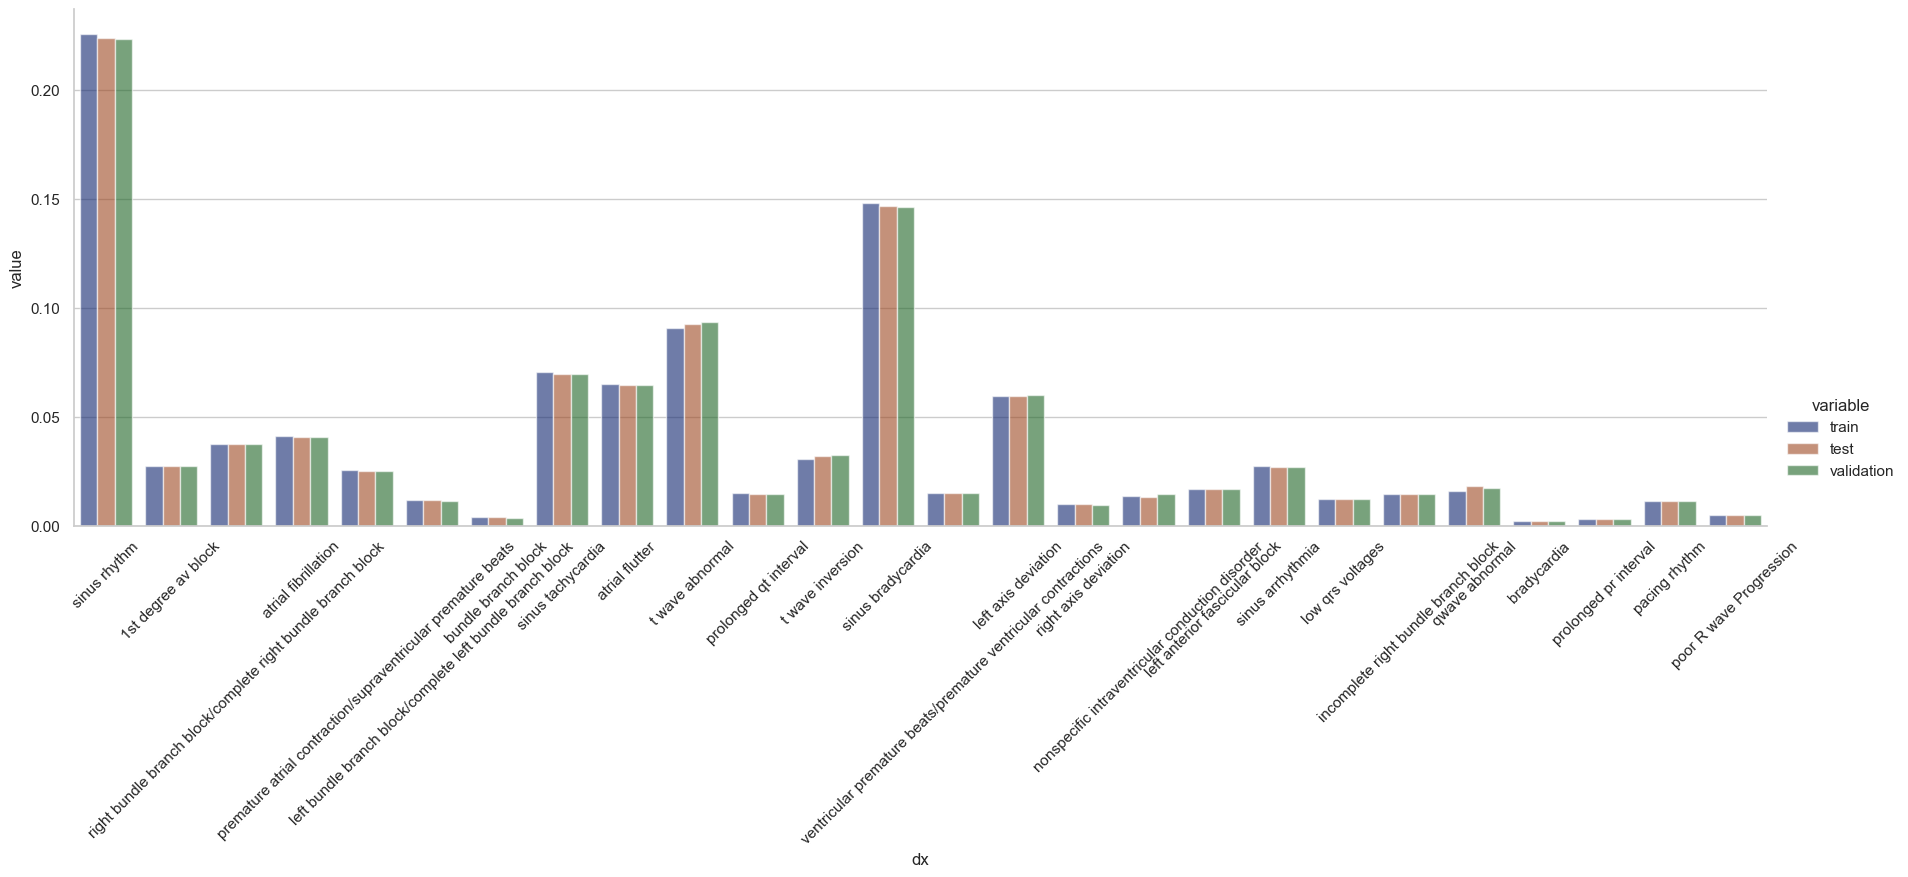

In [66]:
g = sns.catplot(
    data=tmp2, kind="bar",
    x="dx", y="value", hue="variable",
    ci="sd", palette="dark", alpha=.6, height=6, aspect=3
)
plt.xticks(rotation=45)

In [67]:
# Construct a "random" name for our archive.
version_hash = uuid.uuid4().hex
output_name = '../../data/freeze/BROAD_ml4h_klarqvist___physionet__meta_data__graded_splits__' + version_hash + '.pq'
# Store meta data with splits
meta_data_graded.to_parquet(output_name, compression='zstd', compression_level=22)